<a href="https://colab.research.google.com/github/konrad-l/machine_learning_bootcamp/blob/main/supervised/02_regression/04_backward_elimination.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Spis treści:
1. [Import bibliotek](#0)
2. [Wczytanie danych](#1)
3. [Utworzenie kopii danych](#2)
4. [Eksplorcja i wstępne przygotowanie danych](#3)
5. [Podział danych na zbiór treningowy i testowy](#4)
6. [Regresja liniowa](#5)
7. [Dobór cech modelu - eliminacja wsteczna](#6)
8. [Eliminacja wsteczna - automatyzacja](#7)
9. [Zapisanie końcowego modelu](#8)

### <a name='0'></a> Import bibliotek

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

sns.set()
np.random.seed(42)
np.set_printoptions(precision=4, suppress=True)
sklearn.__version__

'1.0.2'

### <a name='1'></a> Wczytanie danych

In [2]:
df_raw = pd.read_csv('https://storage.googleapis.com/esmartdata-courses-files/ml-course/insurance.csv')
df_raw.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


### <a name='2'></a> Utworzenie kopii danych

In [3]:
df = df_raw.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


### <a name='3'></a> Eksplorcja i wstępne przygotowanie danych

In [8]:
# sprawdzenie, które wiersze to duplikaty
df[df.duplicated()]

,age,sex,bmi,children,smoker,region,charges
581,19,male,30.59,0,no,northwest,1639.5631


In [14]:
df[df['charges'] == 1639.5631]

,age,sex,bmi,children,smoker,region,charges
195,19,male,30.59,0,no,northwest,1639.5631
581,19,male,30.59,0,no,northwest,1639.5631


In [15]:
df = df.drop_duplicates()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1337 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1337 non-null   int64  
 1   sex       1337 non-null   object 
 2   bmi       1337 non-null   float64
 3   children  1337 non-null   int64  
 4   smoker    1337 non-null   object 
 5   region    1337 non-null   object 
 6   charges   1337 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 83.6+ KB


In [20]:
# stworzenie listy z nazwami kolumn, które mają zmienne typu 'object'
cat_cols = [col for col in df.columns if df[col].dtype == 'object']
cat_cols

['sex', 'smoker', 'region']

In [22]:
# zmienia dane typu 'object' na 'category'
for col in cat_cols:
  df[col] = df[col].astype('category')

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1337 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   age       1337 non-null   int64   
 1   sex       1337 non-null   category
 2   bmi       1337 non-null   float64 
 3   children  1337 non-null   int64   
 4   smoker    1337 non-null   category
 5   region    1337 non-null   category
 6   charges   1337 non-null   float64 
dtypes: category(3), float64(2), int64(2)
memory usage: 56.6 KB


<ipython-input-22-321f8d11c96d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].astype('category')


In [23]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,1337.0,39.222139,14.044333,18.0000,27.000,39.0000,51.00000,64.00000
bmi,1337.0,30.663452,6.100468,15.9600,26.290,30.4000,34.70000,53.13000
children,1337.0,1.095737,1.205571,0.0000,0.000,1.0000,2.00000,5.00000
charges,1337.0,13279.121487,12110.359656,1121.8739,4746.344,9386.1613,16657.71745,63770.42801


In [24]:
df.describe(include=['category']).T

,count,unique,top,freq
sex,1337,2,male,675
smoker,1337,2,no,1063
region,1337,4,southeast,364


In [26]:
df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [27]:
df['sex'].value_counts()

male      675
female    662
Name: sex, dtype: int64

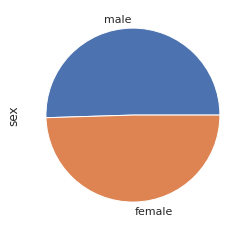

In [30]:
df['sex'].value_counts().plot(kind='pie')

In [31]:
df['smoker'].value_counts()

no     1063
yes     274
Name: smoker, dtype: int64

In [32]:
df['region'].value_counts()

southeast    364
southwest    325
northeast    324
northwest    324
Name: region, dtype: int64

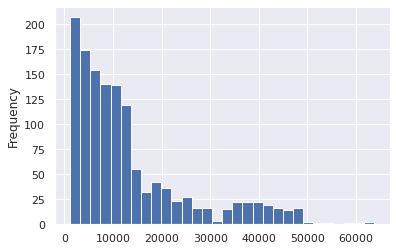

In [33]:
df['charges'].plot(kind='hist', bins=30)

In [34]:
import plotly.express as px
px.histogram(df, x='charges', width=700, height=400, nbins=50, facet_col='smoker', facet_row='sex')

In [35]:
px.histogram(df, x='smoker', facet_col='sex', color='sex', width=700, height=400)

In [36]:
df_dummies = pd.get_dummies(df, drop_first=True)
df_dummies

,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,0,1,0,0,1
1,18,33.770,1,1725.55230,1,0,0,1,0
2,28,33.000,3,4449.46200,1,0,0,1,0
3,33,22.705,0,21984.47061,1,0,1,0,0
4,32,28.880,0,3866.85520,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...
1333,50,30.970,3,10600.54830,1,0,1,0,0
1334,18,31.920,0,2205.98080,0,0,0,0,0
1335,18,36.850,0,1629.83350,0,0,0,1,0
1336,21,25.800,0,2007.94500,0,0,0,0,1


In [38]:
# korelacja poszczególnych zmiennych
corr = df_dummies.corr()
corr

,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
age,1.000000,0.109344,0.041536,0.298308,-0.019814,-0.025587,0.001495,-0.012311,0.009415
bmi,0.109344,1.000000,0.012755,0.198401,0.046397,0.003746,-0.136138,0.270057,-0.006211
children,0.041536,0.012755,1.000000,0.067389,0.017848,0.007331,0.026044,-0.023492,0.021538
charges,0.298308,0.198401,0.067389,1.000000,0.058044,0.787234,-0.038695,0.073578,-0.043637
sex_male,-0.019814,0.046397,0.017848,0.058044,1.000000,0.076596,-0.012482,0.017578,-0.003767
smoker_yes,-0.025587,0.003746,0.007331,0.787234,0.076596,1.000000,-0.036321,0.068282,-0.037168
region_northwest,0.001495,-0.136138,0.026044,-0.038695,-0.012482,-0.036321,1.000000,-0.345909,-0.320493
region_southeast,-0.012311,0.270057,-0.023492,0.073578,0.017578,0.068282,-0.345909,1.000000,-0.346614
region_southwest,0.009415,-0.006211,0.021538,-0.043637,-0.003767,-0.037168,-0.320493,-0.346614,1.000000


<ipython-input-42-9c50a7d78619>:4: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



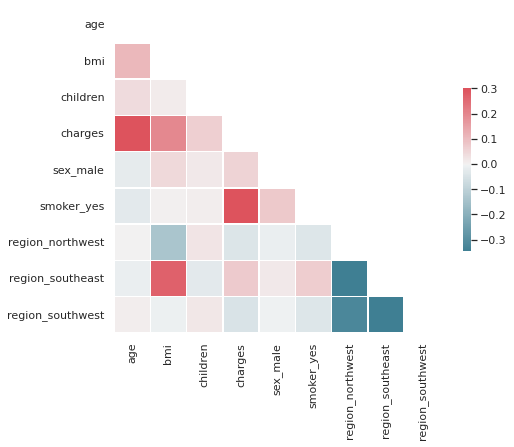

In [42]:
# wyświetlenie mapy ciepła 'heat map' w celu przedstawienia korelacji

sns.set(style='white')
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(8,6))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={'shrink': .5})                

In [44]:
df_dummies.corr()['charges'].sort_values(ascending=False)

charges             1.000000
smoker_yes          0.787234
age                 0.298308
bmi                 0.198401
region_southeast    0.073578
children            0.067389
sex_male            0.058044
region_northwest   -0.038695
region_southwest   -0.043637
Name: charges, dtype: float64

In [56]:
df_dummies.corr()['charges'].sort_values()

region_southwest   -0.043637
region_northwest   -0.038695
sex_male            0.058044
children            0.067389
region_southeast    0.073578
bmi                 0.198401
age                 0.298308
smoker_yes          0.787234
charges             1.000000
Name: charges, dtype: float64

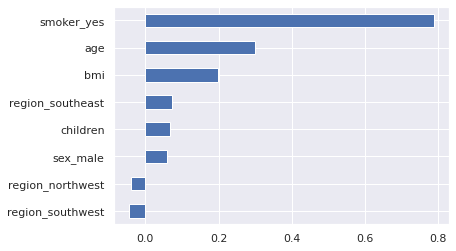

In [67]:
sns.set()
df_dummies.corr()['charges'].sort_values()[:-1].plot(kind='barh')

In [69]:
# przygotowanie 'data' i 'target'

data = df_dummies.copy()
target = data.pop('charges')
data.head()

,age,bmi,children,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27.900,0,0,1,0,0,1
1,18,33.770,1,1,0,0,1,0
2,28,33.000,3,1,0,0,1,0
3,33,22.705,0,1,0,1,0,0
4,32,28.880,0,1,0,1,0,0


In [70]:
target.head()

0    16884.92400
1     1725.55230
2     4449.46200
3    21984.47061
4     3866.85520
Name: charges, dtype: float64

### <a name='4'></a> Podział danych na zbiór treningowy i testowy

In [76]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2)

print(f'X_train shape {X_train.shape}')
print(f'X_test shape {X_test.shape}')
print(f'y_train shape {y_train.shape}')
print(f'y_test shape {y_test.shape}')

X_train shape (1069, 8)
X_test shape (268, 8)
y_train shape (1069,)
y_test shape (268,)


### <a name='5'></a> Regresja liniowa

In [77]:
from sklearn.linear_model import LinearRegression

regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression()

In [81]:
print(f'R2 score: {regressor.score(X_test, y_test):.4f}')

R2 score: 0.7400


In [82]:
y_pred = regressor.predict(X_test)
y_pred[:10]

array([ 2287.6214,  3141.4185,  1248.4128,  5358.1969,  4748.5289,
       39792.3581, 27558.0455,  3104.0174,  3679.5305, 33228.2893])

In [86]:
# moje oblicznie błędu R2
# from sklearn.metrics import r2_score
# r2_score(y_test, y_pred)

0.7399549415931636

In [88]:
# ramka danych dla porównania uzyskanych wyników
y_true = y_test.copy()
predictions = pd.DataFrame({'y_true': y_true, 'y_pred': y_pred})
predictions['error'] = predictions['y_true'] - predictions['y_pred']
predictions.head()

,y_true,y_pred,error
822,1621.88270,2287.621435,-665.738735
430,23082.95533,3141.418505,19941.536825
791,1252.40700,1248.412770,3.994230
408,6652.52880,5358.196892,1294.331908
181,1631.82120,4748.528891,-3116.707691


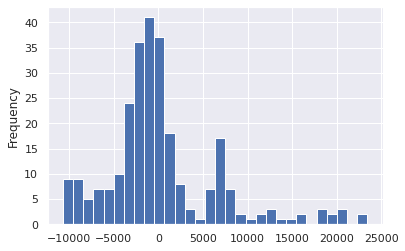

In [93]:
# alternatywny zapis:
# predictions.error.plot(kind='hist', bins=30)
predictions['error'].plot(kind='hist', bins=30)

In [101]:
# obliczanie innego błędu/ metryki Mean absolute error 
# (można byłoby jeszcze np. Mean squared error)

from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(y_true, y_pred)
print(f'MAE wynosi: {mae:.2f}')

MAE wynosi: 4336.58


In [104]:
# punkt przecięcia z osią OY
regressor.intercept_

-12216.344892422172

In [105]:
regressor.coef_

array([  256.8791,   344.1829,   480.2587,   -62.5121, 23702.5064,
        -473.2569,  -834.2698,  -852.8799])

In [109]:
# dla każdej kolumny jest oddzielny współczynnik 'coef_' 
data.columns

Index(['age', 'bmi', 'children', 'sex_male', 'smoker_yes', 'region_northwest',
       'region_southeast', 'region_southwest'],
      dtype='object')

### <a name='6'></a> Dobór cech modelu - eliminacja wsteczna

In [133]:
import statsmodels.api as sm

# ols - ordinary least squares method 
X_train_ols = X_train.copy()
X_train_ols = X_train_ols.values
X_train_ols = sm.add_constant(X_train_ols)
X_train_ols

array([[ 1.   , 20.   , 33.   , ...,  0.   ,  0.   ,  1.   ],
       [ 1.   , 54.   , 31.9  , ...,  0.   ,  1.   ,  0.   ],
       [ 1.   , 58.   , 41.91 , ...,  0.   ,  1.   ,  0.   ],
       ...,
       [ 1.   , 18.   , 23.085, ...,  0.   ,  0.   ,  0.   ],
       [ 1.   , 24.   , 26.79 , ...,  1.   ,  0.   ,  0.   ],
       [ 1.   , 23.   , 37.1  , ...,  0.   ,  0.   ,  1.   ]])

In [128]:
# ols - regresja liniowa w tej bibliotece
ols = sm.OLS(endog=y_train, exog=X_train_ols).fit()
predictors = ['const'] + list(X_train.columns)
print(ols.summary(xname=predictors))

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.753
Model:                            OLS   Adj. R-squared:                  0.752
Method:                 Least Squares   F-statistic:                     404.9
Date:                Sat, 03 Dec 2022   Prob (F-statistic):          5.68e-316
Time:                        13:55:41   Log-Likelihood:                -10811.
No. Observations:                1069   AIC:                         2.164e+04
Df Residuals:                    1060   BIC:                         2.168e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -1.222e+04   1095.085  

**Usuwamy nazwy wierszy, które mają P>|t| większe niż 0,05**

In [129]:
X_selected = X_train_ols[:, [0, 1, 2, 3, 5, 6, 7, 8]]
predictors.remove('sex_male')

ols = sm.OLS(endog=y_train, exog=X_selected).fit()
print(ols.summary(xname=predictors))

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.753
Model:                            OLS   Adj. R-squared:                  0.752
Method:                 Least Squares   F-statistic:                     463.1
Date:                Sat, 03 Dec 2022   Prob (F-statistic):          2.58e-317
Time:                        13:55:44   Log-Likelihood:                -10811.
No. Observations:                1069   AIC:                         2.164e+04
Df Residuals:                    1061   BIC:                         2.168e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -1.224e+04   1082.247  

In [130]:
X_selected = X_train_ols[:, [0, 1, 2, 3, 5, 7, 8]]
predictors.remove('region_northwest')

ols = sm.OLS(endog=y_train, exog=X_selected).fit()
print(ols.summary(xname=predictors))

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.753
Model:                            OLS   Adj. R-squared:                  0.752
Method:                 Least Squares   F-statistic:                     540.3
Date:                Sat, 03 Dec 2022   Prob (F-statistic):          1.62e-318
Time:                        13:55:45   Log-Likelihood:                -10811.
No. Observations:                1069   AIC:                         2.164e+04
Df Residuals:                    1062   BIC:                         2.167e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -1.248e+04   1051.837  

In [131]:
X_selected = X_train_ols[:, [0, 1, 2, 3, 5, 7]]
predictors.remove('region_southwest')

ols = sm.OLS(endog=y_train, exog=X_selected).fit()
print(ols.summary(xname=predictors))

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.753
Model:                            OLS   Adj. R-squared:                  0.752
Method:                 Least Squares   F-statistic:                     647.5
Date:                Sat, 03 Dec 2022   Prob (F-statistic):          1.51e-319
Time:                        13:55:47   Log-Likelihood:                -10812.
No. Observations:                1069   AIC:                         2.164e+04
Df Residuals:                    1063   BIC:                         2.167e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -1.255e+04   1050.767  

In [132]:
X_selected = X_train_ols[:, [0, 1, 2, 3, 5]]
predictors.remove('region_southeast')

ols = sm.OLS(endog=y_train, exog=X_selected).fit()
print(ols.summary(xname=predictors))

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.753
Model:                            OLS   Adj. R-squared:                  0.752
Method:                 Least Squares   F-statistic:                     809.3
Date:                Sat, 03 Dec 2022   Prob (F-statistic):          7.50e-321
Time:                        13:55:49   Log-Likelihood:                -10812.
No. Observations:                1069   AIC:                         2.163e+04
Df Residuals:                    1064   BIC:                         2.166e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.244e+04   1043.619    -11.923      0.0

### <a name='7'></a> Eliminacja wsteczna - automatyzacja

In [139]:
X_train_numpy = X_train.values
X_train_numpy = sm.add_constant(X_train_numpy)
num_vars = len(X_train_numpy[0])

predictors = ['const'] + list(X_train.columns)
sl = 0.05

for i in range(0, num_vars):
  ols = sm.OLS(endog=y_train, exog=X_train_numpy).fit()
  max_pval = max(ols.pvalues.astype('float'))
  if max_pval > sl:
    for j in range(0, num_vars - i):
      if ols.pvalues[j].astype('float') == max_pval:
        X_train_numpy = np.delete(X_train_numpy, j, axis=1)
        predictors.remove(predictors[j])

print(ols.summary(xname=predictors))

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.753
Model:                            OLS   Adj. R-squared:                  0.752
Method:                 Least Squares   F-statistic:                     809.3
Date:                Sat, 03 Dec 2022   Prob (F-statistic):          7.50e-321
Time:                        14:10:40   Log-Likelihood:                -10812.
No. Observations:                1069   AIC:                         2.163e+04
Df Residuals:                    1064   BIC:                         2.166e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.244e+04   1043.619    -11.923      0.0

### <a name='8'></a> Zapisanie końcowego modelu

In [151]:
# zapisanie modelu w folderze Colab, z którym można później pracować
ols.save('model_pickle')